In [7]:
import cv2
from scipy.ndimage import zoom
def getMaskedImage(image, mask, margin=0):
    
    bbox = getBBox(mask, margin = margin)
    if bbox is None:
        return None, None
    
    top_x = bbox[0]
    top_y = bbox[1]
    bottom_x = bbox[2]
    bottom_y = bbox[3]
    
    image_crop = image[top_y:bottom_y, top_x:bottom_x]
    
    return image_crop, (top_x,top_y,bottom_x,bottom_y)

def cropImage(image, coord):
    top_x = coord[0]
    top_y = coord[1]
    bottom_x = coord[2]
    bottom_y = coord[3]
    image_crop = image[top_y:bottom_y, top_x:bottom_x]
    return image_crop

def getBBox(mask, margin = 0):
    _, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not (len(contours)>0):
        return None
    rects = []
    for cnt in contours:
        rects.append(cv2.boundingRect(cnt))
    
    top_x, top_y, bottom_x, bottom_y = 0, 0 ,0, 0
    rects.sort()
    
    top_x = min([x for (x, y, w, h) in rects])  - margin
    top_y = min([y for (x, y, w, h) in rects])  - margin
    bottom_x = max([x+w for (x, y, w, h) in rects]) + margin
    bottom_y = max([y+h for (x, y, w, h) in rects])  + margin
    
    mask_size = mask.shape
    if(top_x < 0 ) : top_x = 0
    if(top_y < 0 ) : top_y = 0
    if(bottom_x >= mask_size[1] ) : bottom_x = mask_size[1]-1
    if(bottom_y >= mask_size[0] ) : bottom_y = mask_size[0]-1
    
    return (top_x,top_y,bottom_x,bottom_y)

def clipped_zoom(img, zoom_factor, **kwargs):
    print(img.shape)
    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out    

In [8]:
#IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
#IMAGENET_RGB_SD = [0.229, 0.224, 0.225]

def hist_match(source, template, cutoff_percentage = (0.0, 0.0)):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
      
    # curoff tamplete - GAEUN
    cutoff_left = int(t_values.shape[0] * cutoff_percentage[0])
    cutoff_right = int(t_values.shape[0] * (1-cutoff_percentage[1]))
    t_values = t_values[cutoff_left:cutoff_right]
    t_counts = t_counts[cutoff_left:cutoff_right]
    

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    return interp_t_values[bin_idx].reshape(oldshape)

def ecdf(x):
    """convenience function for computing the empirical CDF"""
    vals, counts = np.unique(x, return_counts=True)
    ecdf = np.cumsum(counts).astype(np.float32)
    ecdf /= ecdf[-1]
    return vals, ecdf

def plott(source,template,matched):
          
    x1, y1 = ecdf(source.ravel())
    x2, y2 = ecdf(template.ravel())
    x3, y3 = ecdf(matched.ravel())

    fig = plt.figure()
    gs = plt.GridSpec(2, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2], sharex=ax1, sharey=ax1)
    ax4 = fig.add_subplot(gs[1, :])
    for aa in (ax1, ax2, ax3):
        aa.set_axis_off()

    ax1.imshow(source, cmap=plt.cm.gray)
    ax1.set_title('Source')
    ax2.imshow(template, cmap=plt.cm.gray)
    ax2.set_title('template')
    ax3.imshow(matched, cmap=plt.cm.gray)
    ax3.set_title('Matched')

    ax4.plot(x1, y1 * 100, '-r', lw=3, label='Source')
    ax4.plot(x2, y2 * 100, '-k', lw=3, label='Template')
    ax4.plot(x3, y3 * 100, '--r', lw=3, label='Matched')
    ax4.set_xlim(x1[0], x1[-1])
    ax4.set_xlabel('Pixel value')
    ax4.set_ylabel('Cumulative %')
    ax4.legend(loc=5)
    print("aa")

# Step1 : Template image serach

#### (You do not need to do this in Step2-1.)

In [3]:
from collections import OrderedDict
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [4]:
path = '/data3p40/chestbone/CAD2/CAD3/dcmfinewboneoff/' #여기에 이미지 path 지정하기
#lungmask_path = "/home/junguri/data/Pneumonia/LungMask/all/"
cutoff = (0.00, 0.00)

In [6]:
container={}
def Select_Template(dictionary_):
    Ordered_dict = OrderedDict(sorted(dictionary_.items(), key=lambda x: x[1]['mean']))
    idx_ = int(len(dictionary_) / 2)
    
    return list(Ordered_dict.keys())[idx_]

for i, filename in enumerate(os.listdir(path)):
    
    if filename.endswith(".dcm"):
        refimage = sitk.ReadImage(path + filename)
        refimg_array = sitk.GetArrayFromImage(refimage).astype("float32")
        refimg_array = np.expand_dims(refimg_array[0,:,:],-1)
    elif filename.endswith(".png"):
        refimg_array = cv2.imread(path + filename, 1)
    
    '''
    lungmask = cv2.imread(lungmask_path + os.path.splitext(os.path.basename(filename))[0] + ".png", 0)
    refimg_array, _ = getMaskedImage(refimg_array, lungmask, margin = 20)
    if refimg_array is None :
        print ("Empty mask : ", os.path.splitext(os.path.basename(filename))[0])
        continue
    '''
    
    img_array= np.array(refimg_array)
    #img_average = np.mean(refimg_array)
    
    #'''
    source = img_array.ravel()
    s_values, s_counts = np.unique(source, return_counts=True)
    
    cutoff_left = int(s_values.shape[0] * cutoff[0])
    cutoff_right = int(s_values.shape[0] * (1-cutoff[1]))
    s_values = s_values[cutoff_left:cutoff_right]
    s_counts = s_counts[cutoff_left:cutoff_right]
    s_sum = 0
    s_count = 0
    for j in range(s_values.shape[0]) :
        s_sum += s_values[j] * s_counts[j]
        s_count += s_counts[j]
    img_average = s_sum/s_count
    #'''
    
    container.update({filename:{'source_img':img_array, 'mean':img_average}})
    
reffile = Select_Template(container)    
print(reffile)
print(container[reffile]['mean'])

FileNotFoundError: [Errno 2] No such file or directory: '/data3p40/chestbone/CAD2/CAD3/dcmfinewboneoff/'

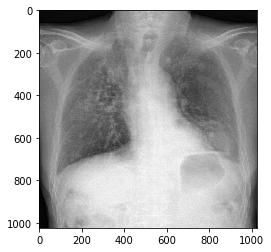

In [6]:
refimg = sitk.ReadImage(path+reffile)
refimg = sitk.GetArrayFromImage(refimg)
plt.imshow(refimg,cmap='gray')
plt.show()

# Step2-3 : HistoMatching with cropped reference : Whole histogram

In [9]:
import os
import numpy as np
import SimpleITK as sitk
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from skimage import exposure, color,img_as_float, transform, img_as_ubyte , io
import csv
from IPython.display import clear_output

#### Reference

In [10]:
ref_file = "/data3p40/chestpanew/asanbundang/train_cad/normalbundang/normal_267.png" 

In [11]:
if ref_file.endswith(".dcm"):
    img_ref = sitk.ReadImage(ref_file)
    img_ref = sitk.GetArrayFromImage(img_ref).astype("float")
    img_ref = np.expand_dims(img_ref[0,:,:],-1)
elif ref_file.endswith(".png"):
    img_ref = cv2.imread(ref_file, 1)

#### HistoMatching

In [13]:
cutoff = (0.20, 0.20) #0.20,0.20 이것은 경험적으로 조절해주면 됨 

In [18]:
def hmdcm():

    path = '/data3p40/chestpanew/chestcadnew/asan/Cardiomegaly_ori/Abnormal/z500cardiplusa_includeother/dcmfi/'
    dst_path = '/data3p40/chestpanew/chestcadnew/asan/Cardiomegaly_ori/Abnormal/z500cardiplusa_includeother/dcmfihm/'
    for i, filename in enumerate(os.listdir(path)):
            # src
            if filename.endswith(".dcm"):
                img = sitk.ReadImage(path + filename)
                img = sitk.GetArrayFromImage(img).astype("float")
                img = np.expand_dims(img[0,:,:],-1)
            elif filename.endswith(".png") or filename.endswith(".jpg"):
                img = cv2.imread(path + filename, 1)

            ori_size = img.shape

            clear_output(wait=False)
            print (i+1," / ",len(os.listdir(path)), " : ",filename)

            '''
            lungmask = cv2.imread(lungmask_path + os.path.splitext(os.path.basename(filename))[0] + ".png", 0)
            if len(lungmask.shape)<3:
                lungmask = np.expand_dims(lungmask,-1)
            if lungmask.shape != ori_size:
                continue
            '''
            # histo matched (lung 부분만을 보기위해 zoom을 해서 reference intensity를 봄)
            # lung mask를 바운더리 만드는 방법 - unet 기반의 솔루션도 존재함 (김민규 박사님 or 이가은 선생님)
            zoom_factor = 1.2

            imagecov = np.array(img_ref)
            zm1 = clipped_zoom(imagecov, zoom_factor)
            plt.imshow(zm1, cmap="gray")
            #plt.show()
            matched = hist_match(img[:,:,0],zm1[:,:,0], cutoff)

            #plt.imshow(matched,cmap='gray')
            #plt.show()
            
            #percentile parameter도 본인이 원하는데로 조정 가능,
            quartile_1m = np.percentile(matched, 25, interpolation ='lower') # 1
            quartile_3m = np.percentile(matched, 75, interpolation ='lower') #92   interpolation ='lower'

            iqrm = quartile_3m - quartile_1m
            mlower_bound = quartile_1m - (iqrm * 1.5)
            mupper_bound = quartile_3m + (iqrm * 1.5)
            mimgsrcrescale = exposure.rescale_intensity(matched, in_range=(mlower_bound, mupper_bound))

            imgl = mimgsrcrescale

            im_shape = (1024,1024)  
            imgconv = transform.resize(imgl, im_shape)
            #print(dst_Path +  "h"+os.path.splitext(os.path.basename(filename))[0]+ '.png')
            #저장하는 방법은 본인이 원하는대로 해도됨
            plt.imsave(dst_path +  os.path.splitext('hm'+os.path.basename(filename))[0]+ '.png',imgconv,cmap="gray")
            img_8bit = cv2.imread(dst_path + os.path.splitext('hm'+os.path.basename(filename))[0] + '.png').astype(np.uint8)   
            cv2.imwrite(dst_path + os.path.splitext('hm'+os.path.basename(filename))[0]+ '.png', color.gray2rgb(img_8bit)) #"hm" #color.gray2rgb(imgl)# RGB (8*3 bit)
print("complete")       

complete


558  /  1115  :  o2532483474391730372537_01Nodule.jpg
(1024, 1024, 3)


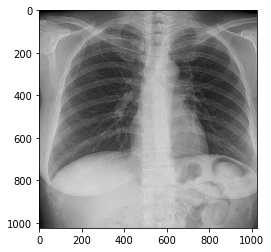

In [19]:
hmdcm()